In [182]:
import os
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from ase.io import read, Trajectory
from ase.io.trajectory import TrajectoryReader
import matplotlib.pyplot as plt
from pymatgen.io.ase import AseAtomsAdaptor
from ase.visualize import view
from ase.geometry import wrap_positions
from ase.data import atomic_masses, covalent_radii


import torch
from torch_geometric.data import Data
from ase import Atoms
from ase.neighborlist import NeighborList
import torch_geometric

In [177]:
# TONS of assumptions made here
def atomic_charges(atomic_nums):
    atomic_nums = np.array(atomic_nums)
    charges = np.zeros(len(atomic_nums)) + 3
    charges[atomic_nums==8] = -2 # Oxygen
    charges[atomic_nums==20] = 2 # Calcium
    charges[atomic_nums==38] = 2 # Barium
    charges[atomic_nums==56] = 2 # Strontium
    return charges


In [178]:
def atoms_to_graph(atoms, index, label, crop_cutoff=4.5, bond_cutoff=1.5):
    """
    Convert an ASE Atoms object to a PyTorch Geometric Data object
    
    Parameters:
    - atoms (ase.Atoms): ASE atoms object
    - index (int): index of atom of interest
    - label (np.array(float)): direction of jump weighted by average jump probability 
    - crop_cutoff (float): Cutoff distance for cropping a cube around given atom
    - bond_cutoff (float): Cutoff distance for neighbors to be edges
    
    Returns:
    - data (torch_geometric.data.Data): PyTorch Geometric Data 
    """

    # Get cell size, position of target atom, and all atom positions
    cell = np.diagonal(atoms.cell) # lattice parameters
    center_pos = atoms.get_positions()[index]
    positions = atoms.get_positions()

    # Shift and rewrap positions so target atom is in center of cell
    shifted_positions = positions - center_pos + 0.5*cell
    center_pos = 0.5*cell
    shifted_positions = wrap_positions(shifted_positions, atoms.cell)
    crop_atoms = atoms.copy()
    crop_atoms.set_positions(shifted_positions)

    # Now apply cropping box around center atom
    crop_sel = np.abs(shifted_positions - center_pos) <= crop_cutoff # Within crop box
    crop_atoms.set_positions(shifted_positions - 0.5*cell) # Now place target atom at origin
    crop_atoms = crop_atoms[np.sum(crop_sel, axis=1) >= 3] # Remove all atoms now fully in bounding box

    # Number of atoms
    num_atoms = len(crop_atoms)
    
    # Step 1: Node Features 
    z = np.reshape(crop_atoms.get_atomic_numbers(), (-1,1)) # Atomic number
    radii = np.reshape(covalent_radii[crop_atoms.get_atomic_numbers()], (-1,1)) # Atomic radii 
    masses = np.reshape(atomic_masses[crop_atoms.get_atomic_numbers()], (-1,1)) # Atomic masses 
    charges = np.reshape(atomic_charges(crop_atoms.get_atomic_numbers()), (-1,1)) # Atomic charges

    pos = crop_atoms.get_positions() # positions are relative to center atom
    x = torch.tensor(np.concatenate((z, radii, masses, charges, pos), axis=1, dtype=np.float64), dtype=torch.float32)

    # Step 2: Construct Neighbor List to Define Edges
    neighbor_list = NeighborList([bond_cutoff] * num_atoms, self_interaction=False, bothways=True)
    neighbor_list.update(crop_atoms)
    
    # Step 3: Extract Edge Index and Attributes
    edge_index = []
    edge_len = []
    new_pos = []
    for i in range(num_atoms):
        neighbors, offsets = neighbor_list.get_neighbors(i)
        for neighbor in neighbors:
            edge_index.append([i, neighbor])
            
            # Calculated Edge Descriptors
            edge_dist = pos[i] - pos[neighbor]
            edge_dist = np.linalg.norm(edge_dist)
            edge_len.append([edge_dist, 1/edge_dist**2])
    
    edge_index = torch.tensor(edge_index, dtype=torch.int64).t().contiguous()
    edge_attr = torch.tensor(edge_len, dtype=torch.float32)

    # Step 4: Add label
    y = torch.tensor(label, dtype=torch.float32).view(1, -1)
    
    # Generate object
    data = Data(x=x, edge_attr= edge_attr, edge_index=edge_index, y=y)
    
    return data, crop_atoms


In [214]:
traj = TrajectoryReader(data_files[9])
atoms = traj[100]
el_indexes = [i for i, a in enumerate(traj[0]) if a.symbol == "O"]

index = np.random.choice(el_indexes, 1)[0]

# Get cell size, position of target atom, and all atom positions
cell = np.diagonal(atoms.cell) # lattice parameters
center_pos = atoms.get_positions()[index]
positions = atoms.get_positions()

# Shift and rewrap positions so target atom is in center of cell
shifted_positions = positions - center_pos + 0.5*cell
center_pos = 0.5*cell
shifted_positions = wrap_positions(shifted_positions, atoms.cell)
crop_atoms = atoms.copy()
crop_atoms.set_positions(shifted_positions)

# Now apply cropping box around center atom
crop_sel = np.abs(shifted_positions - center_pos) < 5 # Within crop box
crop_atoms.set_positions(shifted_positions - 0.5*cell) # Now place target atom at origin
crop_atoms = crop_atoms[np.sum(crop_sel, axis=1) >= 3] # Remove all atoms now fully in bounding box

view(crop_atoms, viewer='x3d')

In [179]:
def atom_displacement(new_pos, old_pos, cell):
    old_pos_shifted = wrap_positions(old_pos - new_pos + 0.5*np.diagonal(cell), cell)
    disp = 0.5*np.diagonal(cell) - old_pos_shifted 
    return disp

In [207]:
def label_feature_gen(filename, epsilon=2.5, element = "Sr", gamma = 0.7, start_idx = 25):
    """
    Process an ASE Trajectory, find moments when a given element hopped sites, and generate features and labels about the event

    Parameters:
     - filename (string): path to trajectory
     - epsilon  (float): angstroms displacment indicating a jump
     - element (string): element to track for site jumps
     - gamma (float): where in the residence time of an atom we sample the environement, zero to one, one takes frame at jump

    Returns:
     - features ([torch_geometric.data.Data]): graphs representing the atoms near a target before a jump event
     - labels ([float]): list of residence times in simulation steps for a given jump event
     - atoms_snippets ([ase.Atoms]): list of cropped atoms used to generate each graph
    """
    print("Processing ", filename, "...")
    traj = TrajectoryReader(filename)
    print("Trajectory is ", len(traj), " frames long")

    el_indexes = [i for i, a in enumerate(traj[0]) if a.symbol == element]
    n_idxs = len(el_indexes)

    # Data logging variables
    features = []
    labels = []
    atoms_snippets = []
    total_jumps = np.zeros((n_idxs)) # Number of times an atom has jumped
    last_jump = np.zeros((n_idxs)) # Timestep when the atom last jumped

    # Initialize last stable position
    last_seen = traj[start_idx].positions.copy() # Last position where 'jump' recorded

    # Iterate over each timestep
    for i in range(start_idx+1, len(traj)): # time step
        current_pos = traj[i].positions
        cell = traj[i].get_cell() # cell size at current position
        disp = atom_displacement(current_pos, last_seen, cell)
        disp_norm = np.linalg.norm(disp, axis = 1) # displacement
        jumps = disp_norm > epsilon # Jump defined by epsilon displacement
        last_seen[jumps] = current_pos[jumps] # Set new positions for atoms that have completed a jump

        # Now only consider chosen element
        jumps = jumps[el_indexes] # Restrict jumps to relevant atoms
        total_jumps += jumps # Log number of jumps per atom

        # Check each atoms and log jumps (not including first)
        for j in range(n_idxs): # atom idx
            if jumps[j]:
                if last_jump[j]>0:
                    frame_idx = int(np.ceil(gamma*i+(1-gamma)*last_jump[j])) # Middle frame of jump residence time
                    
                    # Labels: Find jump direction and weight based on residence time
                    last_jump_pos = traj[int(last_jump[j])].positions
                    jump_disp = atom_displacement(current_pos, last_jump_pos, cell)[j]
                    
                    direction = (jump_disp)/np.linalg.norm(jump_disp) # Normalized direction
                    residence_time = float(i-last_jump[j]) # Number of steps since last jump
                    # TODO: Change this back to directions 
                    label = direction/(0.1*residence_time)   # jump probability in units [1/ps]
                    labels.append(label) # Direction is weighted by jump probability per step

                    # Features: generate graphs
                    graph_feat, crop_atoms = atoms_to_graph(traj[frame_idx], j, label) # Generate features
                    features.append(graph_feat) # Generate features
                    
                    # Cropped atoms near target
                    atoms_snippets.append(crop_atoms)
                
                last_jump[j] = i  # Set previous jump time                   

    print("Recorded ", np.sum(total_jumps), " jumps in trajectory \n")
    labels = np.array(labels)

    return features, labels, atoms_snippets

In [209]:
directory = "trajs/"
data_files = [os.path.join(directory, file) for file in os.listdir(directory) if os.path.isfile(os.path.join(directory, file))]

X = []
y = []
atoms_list = []

for filename in data_files:
    feature, label, atoms_snippet = label_feature_gen(filename, epsilon=3, element = "O")
    X += feature
    y.append(label)
    atoms_list += atoms_snippet

y = np.concatenate(y)

Processing  trajs/md_diffusion_HEPO-La13Sr13Ca13Nd13Gd13Y13Ba13Fe8Co2O95_N4_1573K.traj ...
Trajectory is  250  frames long
Recorded  820.0  jumps in trajectory 

Processing  trajs/md_diffusion_HEPO-La13Sr13Ca13Sm13Nd13Gd13Ba13Fe8Co2O95_N4_1573K.traj ...
Trajectory is  250  frames long
Recorded  761.0  jumps in trajectory 

Processing  trajs/md_diffusion_HEPO-La13Sr13Ca13Sm13Nd13Gd13Y13Fe8Co2O95_N4_1573K.traj ...
Trajectory is  250  frames long
Recorded  834.0  jumps in trajectory 

Processing  trajs/md_diffusion_HEPO-La15Sr15Ca15Sm15Nd15Ba15Fe8Co2O95_N4_1573K.traj ...
Trajectory is  250  frames long
Recorded  805.0  jumps in trajectory 

Processing  trajs/md_diffusion_HEPO-La15Sr15Ca15Sm15Nd15Gd15Fe8Co2O95_N4_1573K.traj ...
Trajectory is  250  frames long
Recorded  804.0  jumps in trajectory 

Processing  trajs/md_diffusion_HEPO-La15Sr15Sm15Gd15Y15Ba15Fe8Co2O95_N4_1573K.traj ...
Trajectory is  250  frames long
Recorded  797.0  jumps in trajectory 

Processing  trajs/md_diffusion_HEPO-L

In [210]:
# Save Generated Graphs
torch.save(X, 'graph_list.pt')


# Save each Atoms object into a single .traj file (append mode)
with Trajectory('atoms_list.traj', 'w') as traj:
    for atoms in atoms_list:
        traj.write(atoms)

5412


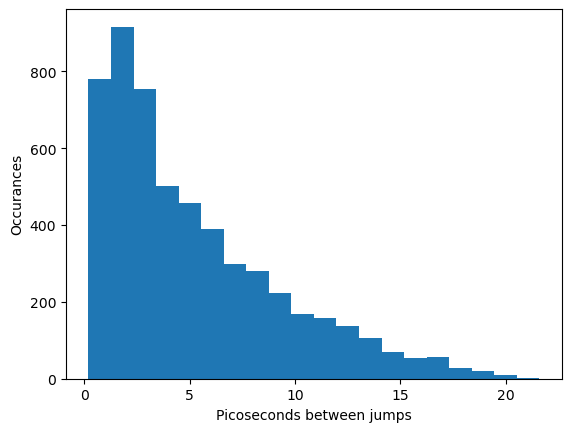

In [211]:
print(len(y))
plt.hist(1/np.linalg.norm(y,axis=1), bins=20)
plt.xlabel("Picoseconds between jumps")
plt.ylabel("Occurances")
plt.show()

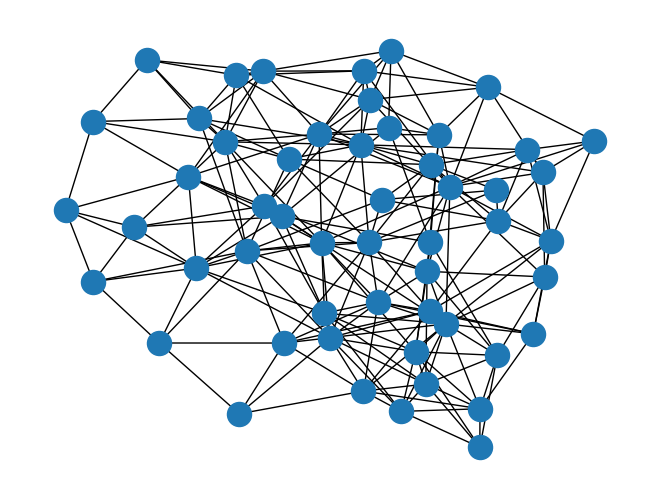

In [153]:
import networkx as nx
g = torch_geometric.utils.to_networkx(X[101], to_undirected=True)
nx.draw(g)

C:\Users\adamp\AppData\Local\Temp\ipykernel_43424\3134041674.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(x, x/3-np.log(x))


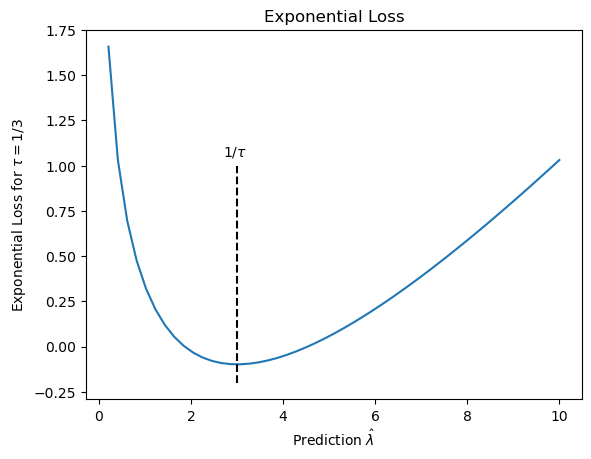

In [154]:
x = np.linspace(0, 10)
plt.plot(x, x/3-np.log(x))
plt.plot([3,3], [-0.2, 1], 'k--')
plt.text(2.7, 1.05, r'1/$\tau$')
plt.ylabel(r'Exponential Loss for $\tau=1/3$')
plt.xlabel(r'Prediction $\hat{\lambda}$')
plt.title("Exponential Loss")
plt.show()

In [ ]:

view(atoms_list[101], viewer='x3d')

In [140]:
"""
from matminer.featurizers.site.bonding import BondOrientationalParameter, AverageBondLength, AverageBondAngle
from matminer.featurizers.site.fingerprint import AGNIFingerprints
from matminer.featurizers.site.rdf import GaussianSymmFunc
from matminer.featurizers.site.chemical import EwaldSiteEnergy, ChemicalSRO, LocalPropertyDifference


    ## Loop through Site featurizers
    property_list = ("Number", "AtomicWeight", "Electronegativity", "CovalentRadius")  # For SiteElementalProperty function
    site_feature_functions = [AGNIFingerprints(cutoff=5, directions=[None])]#, GaussianSymmFunc(cutoff=5), LocalPropertyDifference(properties=property_list), AverageBondLength()]
    # Wishlist: EwaldSiteEnergy(), 
    site_features = {}
    for featurizer in site_feature_functions:
        colnames = featurizer._generate_column_labels(multiindex=False, return_errors=False)
        for i in range(n_idxs): # Atoms
            for j in range(len(jump_idxs[i])): # Jump occurance
                traj_frame = jump_idxs[i][j]
                index = int(el_indexes[i])
                feat = featurizer.featurize(AseAtomsAdaptor.get_structure(traj[traj_frame]), idx=index)
                site_name = "Atom %i Jump %i" % (i, j)
                site_features[site_name].update(dict(zip(colnames, feat)))
                site_features[site_name].update({"Residence Frames" : residence_times[i][j]})

"""

'\nfrom matminer.featurizers.site.bonding import BondOrientationalParameter, AverageBondLength, AverageBondAngle\nfrom matminer.featurizers.site.fingerprint import AGNIFingerprints\nfrom matminer.featurizers.site.rdf import GaussianSymmFunc\nfrom matminer.featurizers.site.chemical import EwaldSiteEnergy, ChemicalSRO, LocalPropertyDifference\n\n\n    ## Loop through Site featurizers\n    property_list = ("Number", "AtomicWeight", "Electronegativity", "CovalentRadius")  # For SiteElementalProperty function\n    site_feature_functions = [AGNIFingerprints(cutoff=5, directions=[None])]#, GaussianSymmFunc(cutoff=5), LocalPropertyDifference(properties=property_list), AverageBondLength()]\n    # Wishlist: EwaldSiteEnergy(), \n    site_features = {}\n    for featurizer in site_feature_functions:\n        colnames = featurizer._generate_column_labels(multiindex=False, return_errors=False)\n        for i in range(n_idxs): # Atoms\n            for j in range(len(jump_idxs[i])): # Jump occurance\n 